# Projeto ML: Classificação de Depósitos Bancários

## Foco: Regressão Logística, Pré-Processamento e Validação

O objetivo é realizar a Análise Exploratória (EDA) do dataset bancário para prever se um cliente irá subscrever um depósito a prazo (`y`).

### Objetivos da EDA

1.  **Inspeção Inicial:** Verificar tipos de dados, valores nulos e estatísticas descritivas.
2.  **Análise do Alvo:** Avaliar o desbalanceamento da variável de saída (`y`).
3.  **Planejamento do Pré-Processamento:** Identificar variáveis categóricas para Encoding e variáveis numéricas para Escalonamento.
---

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# carregando o dataset
df = pd.read_csv("../data/bank-full.csv", sep=';')

print("Tamanho do dataset: ", df.shape)
print("\nPrimeiras linhas do dataset:\n", df.head())


Tamanho do dataset:  (45211, 17)

Primeiras linhas do dataset:
    age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [11]:
print("\nInformações do dataset:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

Informações do dataset:
 None


## Resumo da Inspeção Inicial (Pré-Feature Engineering)

A inspeção inicial do DataFrame revelou os seguintes pontos cruciais que guiarão o pré-processamento para o modelo de Regressão Logística:

* **Valores Ausentes (NaN):** Não foram encontrados valores nulos.
* **Variáveis Categóricas:** 10 colunas são do tipo `object` e exigirão codificação numérica.
* **Próximos Passos:**
    1.  **Desbalanceamento de Classes:** A distribuição do alvo `y` precisa ser verificada, pois o modelo de classificação será sensível a ele.
    2.  **Tratamento de 'unknown':** É necessário quantificar a presença da *string* `'unknown'` nas colunas categóricas, pois ela funciona como um valor ausente.

In [12]:
# análise da variável alvo
print("\nDistribuição da variável alvo 'y':\n", df['y'].value_counts(normalize=True))

# identificação de valores ausentes (unknown)
print("\nContagem de 'unknown' em colunas categóricas:")

categorical_cols = df.select_dtypes(include=['object']).columns
feature_cols = categorical_cols.drop('y', errors='ignore')

for col in feature_cols:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        percent_unknown = (unknown_count/len(df))*100
        print(f"'{col}': {unknown_count} entradas ({percent_unknown:.2f}%)")


Distribuição da variável alvo 'y':
 y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

Contagem de 'unknown' em colunas categóricas:
'job': 288 entradas (0.64%)
'education': 1857 entradas (4.11%)
'contact': 13020 entradas (28.80%)
'poutcome': 36959 entradas (81.75%)


Com base na análise inicial, o pré-processamento será dividido em três etapas principais para preparar os dados para o modelo de Regressão Logística:

### 1. Codificação da Variável Alvo e Binárias

* **Target (`y`):** Mapeamento binário (`yes` $\rightarrow 1$, `no` $\rightarrow 0$).
* **Binárias Simples:** Colunas como `default`, `housing`, e `loan` serão convertidas para $1$ e $0$.

### 2. Codificação de Variáveis Ordinais

* **`month`:** Será codificada numericamente (Label Encoding) seguindo a ordem temporal correta (1 a 12).
* **`education`:** (Será tratada no One-Hot Encoding ou como Ordinal no próximo passo, dependendo da interpretação do `'unknown'`).

### 3. Codificação de Variáveis Nominais e Tratamento de 'unknown'

* As colunas categóricas restantes (`job`, `education`, `marital`, `contact`, `poutcome`) serão codificadas usando **One-Hot Encoding**.
* O One-Hot Encoding (via `pd.get_dummies()`) é ideal aqui, pois ele criará automaticamente uma coluna para a categoria `'unknown'`, o que é útil para capturar se o *desconhecido* é preditivo para a subscrição do depósito.

In [ ]:
# --- Etapa 1: Codificação da variável alvo e binárias ---

df['y'] = df['y'].map({'yes': 1, 'no': 0})
print("\nDistribuição da variável alvo 'y' após codificação:\n", df['y'].value_counts(normalize=True))

binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})


# --- Etapa 2: Codificação da variável 'month' ---

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

df['month'] = df['month'].cat.codes + 1  # +1 para começar de 1 (jan=1, feb=2, ..., dec=12)

print("\nVerificação dos tipos de dados após a codificação:\n")
print(df[['month', 'loan', 'housing', 'default', 'y']].dtypes)



Distribuição da variável alvo 'y' após codificação:
 y
0    0.883015
1    0.116985
Name: proportion, dtype: float64

Verificação dos tipos de dados após a codificação:

month       int8
loan       int64
housing    int64
default    int64
y          int64
dtype: object


In [17]:
# --- Etapa 3: Codificação das variáveis nominais ---

nominal_cols = ['job', 'marital', 'education', 'contact', 'poutcome']

# aplicando One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)

print("\n--- Verificação após One-Hot Encoding ---")
print(f"Novo Tamanho do Dataset: {df_encoded.shape}")
print("\nTipos de Dados:")
print(df_encoded.info())


--- Verificação após One-Hot Encoding ---
Novo Tamanho do Dataset: (45211, 33)

Tipos de Dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  int64
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  int64
 4   loan                 45211 non-null  int64
 5   day                  45211 non-null  int64
 6   month                45211 non-null  int8 
 7   duration             45211 non-null  int64
 8   campaign             45211 non-null  int64
 9   pdays                45211 non-null  int64
 10  previous             45211 non-null  int64
 11  y                    45211 non-null  int64
 12  job_blue-collar      45211 non-null  int64
 13  job_entrepreneur     45211 non-null  int64
 14  job_housemaid        

### Separação de Dados e Treinamento do Modelo

Com o Feature Engineering concluído, o próximo passo é preparar os dados finais e treinar o modelo de Machine Learning.

### 1. Separação (Split)

* O conjunto de dados é dividido em **Treino (80%)** e **Teste (20%)** usando `train_test_split`.
* Utilizaremos o parâmetro `stratify=y` para garantir que o **desbalanceamento de classes** (88% 'no' vs. 12% 'yes') seja mantido proporcionalmente em ambos os conjuntos.

### 2. Escalonamento

* As *features* numéricas (`age`, `balance`, `duration`, etc.) são padronizadas usando **`StandardScaler`**.

### 3. Modelagem

* O modelo de **Regressão Logística** será treinado para estabelecer a *baseline* de desempenho para este problema de classificação binária.
---

In [18]:
# split e escalonamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# selecionando colunas numéricas para escalonamento

numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# treinamento do modelo
modelo = LogisticRegression(max_iter=1000, random_state=42)
modelo.fit(X_train, y_train)

print("\nModelo treinado com sucesso!")


Modelo treinado com sucesso!


### Validação do Modelo

Focaremos na avaliação do desempenho do modelo de Regressão Logística no conjunto de dados de teste (dados não vistos).

Dada a natureza do problema e o **desbalanceamento de classes** (aproximadamente 88% 'no' vs. 12% 'yes'), a **Acurácia** é uma métrica insuficiente.

**Foco da Análise:**

1.  **Matriz de Confusão:** Para entender onde o modelo está errando (Falsos Positivos e Falsos Negativos).
2.  **Recall (Revocação):** Quão bem o modelo consegue identificar a classe minoritária ('yes'). Esta é a métrica mais crítica, pois queremos maximizar a captação de clientes que subscreverão o depósito.
3.  **F1-Score:** Média harmônica entre Precisão e Recall.
4.  **AUC-ROC:** Avalia a capacidade de discriminação do modelo ao longo de todos os limiares.
---

In [19]:
# previsões e avaliação

y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1] # probabilidades para AUC 

# matriz de confusão
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# relatório de classificação
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# AUC-ROC
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc_score:.4f}")


Matriz de Confusão:
 [[7804  181]
 [ 731  327]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.64      0.31      0.42      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043

AUC-ROC: 0.8909


### Insights da Validação (Regressão Logística - Baseline)

A avaliação do modelo **Baseline** (Regressão Logística) no conjunto de teste revelou uma performance mista, fortemente influenciada pelo **desbalanceamento de classes** (88% 'no' vs. 12% 'yes'):

### 1. Pontos Fortes

* **Acurácia e AUC:** A **Acurácia de 0.90** e o **AUC-ROC de 0.8909** são fortes. O alto AUC indica que o modelo tem uma excelente capacidade de **discriminação** entre as classes.

### 2. Ponto de Falha Crítico

* **Falsos Negativos (731):** Este é o maior erro. O modelo está falhando em identificar **731 clientes** que realmente iriam subscrever o depósito.
* **Baixo Recall (Classe 1):** O **Recall de 0.31** (31%) para a classe 'yes' é inaceitável para um problema de marketing, pois significa que a campanha estaria perdendo a maioria dos clientes positivos.

### 3. Plano de Ação

O problema não é o poder preditivo do modelo (dado o alto AUC), mas sim a sua **calibração**. O limiar de decisão padrão (0.5) é muito alto, levando o modelo a ser excessivamente conservador e prever 'no' na maioria das vezes. 

O próximo passo é realizar uma **análise da curva ROC e do limiar de decisão** para encontrar um novo ponto de corte que maximize o **Recall** (capturando mais clientes 'yes'), mantendo a **Precisão** em um nível aceitável.

---

AUC: 0.8909


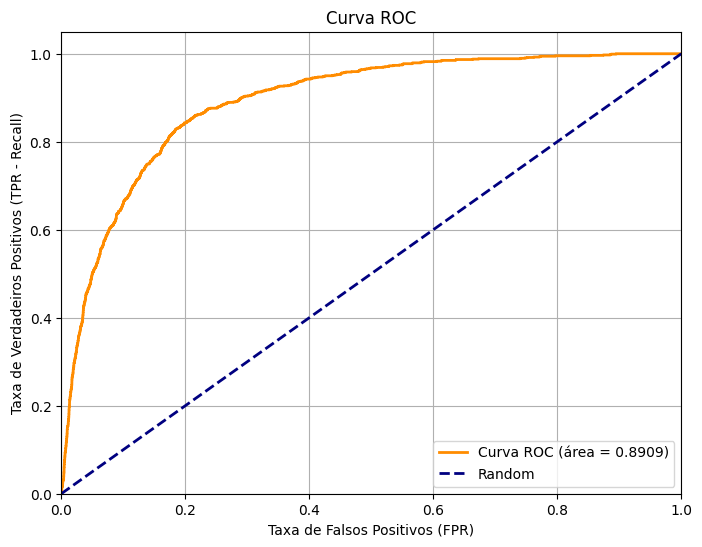

--------------------------------------------------

Análise de Thresholds:

     Threshold    Recall  Precision
442   0.291243  0.500000   0.950031
443   0.291054  0.500000   0.949906
444   0.290424  0.500945   0.949906
445   0.289776  0.500945   0.949656
446   0.288588  0.502836   0.949656


In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

# plot da curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR - Recall)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print('-'*50)

# criando um DataFrame para análise de thresholds
thresholds_df = pd.DataFrame({
    'Threshold': thresholds,
    'Recall': tpr,
    'Precision': 1 - fpr # 1 - FPR é a precisão aproximada
})

print("\nAnálise de Thresholds:\n")
print(thresholds_df[thresholds_df['Recall'] >= 0.5].head()) # filtrando thresholds com Recall maior que 50%

### Aplicação e Resultados Finais do *Threshold* Otimizado

A análise da Curva ROC e dos *thresholds* confirmou que o modelo tem alto poder discriminatório (AUC: 0.8909), mas estava mal calibrado pelo limiar padrão (0.5), resultando em baixo Recall (0.31).

### Decisão Estratégica

Para priorizar a identificação de clientes 'yes' (maximizando o Recall), o limiar de decisão será ajustado para o valor que garante, no mínimo, **50% de Recall** (Taxa de Verdadeiros Positivos).

* **Limiar Otimizado Escolhido:** **0.291243**

Este novo limiar será aplicado às probabilidades preditas para gerar novas classificações e reavaliar o desempenho do modelo em relação às métricas de negócio (Recall e F1-Score).

---

In [22]:
# definindo o threshold otimizado
OPTIMAL_THRESHOLD = 0.291243

# criando nova previsão
y_pred_optimized = (y_proba >= OPTIMAL_THRESHOLD).astype(int)

print(f"--- Revalidação com Limiar Otimizado ({OPTIMAL_THRESHOLD:.4f}) ---")
# matriz de confusão otimizada
print("\nMatriz de Confusão (Threshold Otimizado):\n", confusion_matrix(y_test, y_pred_optimized))

# relatório de classificação otimizado
print("\nRelatório de Classificação (Threshold Otimizado):\n", classification_report(y_test, y_pred_optimized))

--- Revalidação com Limiar Otimizado (0.2912) ---

Matriz de Confusão (Threshold Otimizado):
 [[7586  399]
 [ 530  528]]

Relatório de Classificação (Threshold Otimizado):
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      7985
           1       0.57      0.50      0.53      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.72      0.74      9043
weighted avg       0.89      0.90      0.89      9043

